# GLAD Alert widgets

In [1]:
#Import Global Metadata etc

%run '0.Importable_Globals.ipynb'

In [2]:
from datetime import date
from datetime import timedelta
import datetime
import math


# Test

We need to precalc weekly stats over the entirety of the temporal data.

In [ ]:
test_i = '2015-01-01'

In [ ]:
date_1 = datetime.strptime(test_i, "%Y-%m-%d")
date_1

In [ ]:
date_2 = date_1 + timedelta(days=7) 
date_2

In [ ]:
test_f = datetime.isoformat(date_2)[:10]
test_f

In [ ]:
test_data = get_glads(start_date=test_i, end_date=test_f, iso=iso, adm1=adm1, threshold=threshold)

In [ ]:
test_data

# Dynamic Sentences


In [ ]:
print(f"There were {historic_data[w].get('count')} GLADS alerts reported ", end="")
print(f"in the week starting {historic_data[week].get('start_date')}, ", end="")
print(f"compared to ", end="")
n = 1

while week-(52*n) > 0:
    if n > 1:
        print(f", ", end="")
    if historic_data[week-(52*n)].get('start_date')[0:4] == '2015':
        print(f"and ", end="")
        
    if historic_data[week-(52*n)].get('count') > historic_data[week-(52*(n-1))].get('count'):
        arrow = '↑'
    elif historic_data[week-(52*n)].get('count') < historic_data[week-(52*(n-1))].get('count'):
        arrow = '↓'
    else:
        arrow = '-'
        
    print(f"{historic_data[week-(52*n)].get('count')}({arrow}) ", end="")
    print(f"in {historic_data[week-(52*n)].get('start_date')[0:4]}", end="")
    n += 1
    
print(f".", end="")
    
### Note: (↑) indicates that current year is an increse over that year, (↓) means a decrease 

In [ ]:
print(f"There were {historic_data[w].get('count')} GLADS alerts reported ", end="")
print(f"in the week starting {historic_data[week].get('start_date')}, ", end="")

if historic_data[week].get('count') > historic_data[week-52].get('count') and historic_data[week-52].get('count'):
    print(f"an increase of {historic_data[week].get('count') - historic_data[week-52].get('count')} ", end="")
else:
    print(f"an decrease of {historic_data[week].get('count') - historic_data[week-52].get('count')} ", end="")
    
print(f"over the corresponding week in {historic_data[week-52].get('start_date')[0:4]}. ", end="")
    
    

### Daily/Weekly/Monthly Alerts 

We should get Alerts over several time periods are a range of different temporal resolutions.
We need to calculate:

1. Last date in the returned data (and convert it to a real date)
1. depending on a variable time selection (e.g. past week, past 3 weeks, past 3 months, past 6 months) select back in time (including a leading period to use as a smooth)
1. select the same time window for all previous years, and composite/stack the time together
1. create a boxcar smooth mean to use as the center of the certainty range
1. calculate a single standard deviation for the whole period (which should be the average standard deviation of all the individual time-point standard deviations)
1. test plot, floor the sigma range at 0

In [3]:
iso = 'PER'
adm1 = None
adm2 = None

In [4]:
%%time
#Just return all data for period aggregated by keyword (day/week/year)
url = f'https://production-api.globalforestwatch.org/glad-alerts/admin/{iso}?aggregate_values=true&aggregate_by=day'

r = requests.get(url)
r.url

CPU times: user 3.78 ms, sys: 1.73 ms, total: 5.51 ms
Wall time: 6.5 ms


In [5]:

retuned_values = r.json().get('data',None).get('attributes', None).get('value', None)

tmp_list = []
for row in retuned_values:
    tmp_list.append([row.get('year', None),
                     row.get('month', None),
                     row.get('week', None),
                     row.get('count', None),
                     row.get('julian_day', None)])
df = pd.DataFrame(tmp_list, columns=['year','month','week','count','julian_day'])
df.head()

,year,month,week,count,julian_day
0,2015,None,None,8,1
1,2015,None,None,43,2
2,2015,None,None,2,8
3,2015,None,None,29,9
4,2015,None,None,105,10


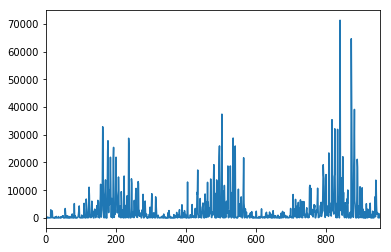

In [6]:
### Sorts by year, then month etc etc
df.sort_values(['year','month', 'week','julian_day'])['count'].plot()

In [7]:
len(df)

956

In [8]:
retuned_values[0]

{'alert_date': '2015-01-01', 'count': 8, 'julian_day': 1, 'year': 2015}

# Functions

In [9]:
def glads_queries(iso, adm1=None, adm2=None, period='day'):

    if period in ['day','week','month']:
        
        if adm2:
            print(f'Requesting adm2 alerts aggregated by {period}')
            url = f'https://production-api.globalforestwatch.org/glad-alerts/admin/{iso}/{adm1}/{adm2}?aggregate_values=true&aggregate_by={period}'
        elif adm1:
            print(f'Requesting adm1 alerts aggregated by {period}')
            url = f'https://production-api.globalforestwatch.org/glad-alerts/admin/{iso}/{adm1}?aggregate_values=true&aggregate_by={period}'
        elif iso:
            print(f'Requesting adm0 alerts aggregated by {period}')
            url = f'https://production-api.globalforestwatch.org/glad-alerts/admin/{iso}?aggregate_values=true&aggregate_by={period}'
    
        r = requests.get(url)
        print(r.url)

        return r.json().get('data',None).get('attributes', None).get('value', None)
    
    else:
        print("Unable to handle request")

In [135]:
def create_df(alert_data):
    
    tmp_list = []
    for row in retuned_values:
        tmp_list.append([row.get('year', None),
                         row.get('month', None),
                         row.get('week', None),
                         row.get('count', None),
                         row.get('julian_day', None)])
    df = pd.DataFrame(tmp_list, columns=['year','month','week','count','julian_day'])
    
    return df

In [136]:
def plot_df(df):
    
     return df.sort_values(['year','month', 'week','julian_day'])['count'].plot()

In [137]:
def get_start_date(df):
    
    last_index = len(df) - 1
    julian_day = str(df.at[last_index,'julian_day'])
    current_year = str(df.at[last_index,'year'])
    

    date = datetime.datetime.strptime(current_year + julian_day, '%Y%j').date()
    return date.strftime('%Y-%m-%d')

In [138]:
data = glads_queries(iso=iso, adm1=adm1, adm2=adm2, period='day')

Requesting adm0 alerts aggregated by day
https://production-api.globalforestwatch.org/glad-alerts/admin/PER?aggregate_values=true&aggregate_by=day


In [141]:
df = create_df(data)

In [142]:
df.head()

,year,month,week,count,julian_day
0,2015,None,None,8,1
1,2015,None,None,43,2
2,2015,None,None,2,8
3,2015,None,None,29,9
4,2015,None,None,105,10


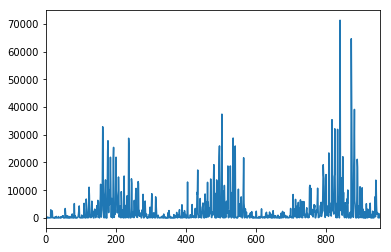

In [143]:
plot_df(df)

In [50]:
get_start_date(df)

'2017-12-25'

In [ ]:
def get_glads_stats(df, time_frame='1w', window=7):
    
    if time_frame == '1w':
        dt = timedelta(days=7)
        period = 'day'
    elif time_frame == '3w':
        dt == timedelta(days=21)
        period = 'day'
    
    last_index = len(df) - 1
    
    

In [53]:
last_index = len(df) - 1
last_index

955

In [58]:
start_day = df.at[last_index,'julian_day']

In [159]:
start_day

359

In [161]:
# Get same day from previous years +/- 'window'

window = 7

tmp = df[df['julian_day'].between(start_day-window, start_day+window, inclusive=True)]
tmp

### NOTE: does not yet handle wrapping across year dates (ie. jd: 364, 365, 1, 2 etc)

,year,month,week,count,julian_day
289,2015,None,None,20,354
290,2015,None,None,197,356
291,2015,None,None,4,360
292,2015,None,None,187,362
293,2015,None,None,64,363
294,2015,None,None,375,364
608,2016,None,None,17,352
609,2016,None,None,510,353
610,2016,None,None,23,354
611,2016,None,None,5,355


In [178]:
mean = np.mean(tmp['count'])

In [174]:
mean

453.15384615384613

In [170]:
5*window - len(tmp)

9

26

### Daily/Weekly/Monthly Alerts 

We should get Alerts over several time periods are a range of different temporal resolutions.
We need to calculate:

1. Last date in the returned data (and convert it to a real date)
1. depending on a variable time selection (e.g. past week, past 3 weeks, past 3 months, past 6 months) select back in time (including a leading period to use as a smooth)
1. select the same time window for all previous years, and composite/stack the time together
1. create a boxcar smooth mean to use as the center of the certainty range
1. calculate a single standard deviation for the whole period (which should be the average standard deviation of all the individual time-point standard deviations)
1. test plot, floor the sigma range at 0